# CIS 545 Final Project: Amazon Review Analysis and Classification



In hw4, we have finished some data processing jobs (like PCA or TF-IDF scores) and also tried several models, such like Random Forest, t-SNE and k-means to predict the rating of the reviews. But all the results are not so satisfying. Therefore, in this project, we will continually did. some work to improve the accuracy of our model. To achieve this goal, this project would be divided into five main parts below (including the preparing section): 

0.   Preparing section: download the raw data and inherit somr required data from previous homework.

1.   Hyperparameter Tunning for Random Forest: try to improve the modeling for choosing different value of parameters.

2.   Try several frequently used model and see if the accuracy was improved.
3.   Neural Network: in this part, we tried two ways: one simple NN and the other is LSTMs.


4.   how date of the reviews will influence the prediction accuracy of models.



In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

Make sure the following line prints the up-to-date version of `gensim`, which at time of releasing this homework was version 3.8.1. 

In [0]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter


In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
# get the raw dataset
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000))) # 4000 * 5 ndarray
y = np.repeat(y, 5) # (4000 * 5 * 5) * 1 (1D-ndarray)

###Step 0: inherit the required data from hw4

### step 0.0: load the required function from hw4

##### step: 0.0.1: functions for processing the text contents

In [0]:
# functions about reviews

def lookup_docs(corpus, indices):
  idx = 0
  new_corpus = []
  for doc in corpus:
      if (idx in indices):
        new_corpus.append(doc)
      idx += 1
  return new_corpus


def translate_review(review, reviews_dict):
    Line = ""
    for (idx, times) in review:
      for i in range(int(times)):
        Line += reviews_dict.get(idx, "") + " "
    return Line


#### step: 0.0.2: functions for processing date datasets

In [0]:
# functions about reviews' time

def convert_times(reviews_times):
  # return reviews_times
  date_series = pd.Series([])
  for time in reviews_times:
    date = datetime.fromtimestamp(time)
    date_series = date_series.append(pd.Series(date), ignore_index = True)
  return date_series


def days_before(time_item, offset):
  from datetime import timedelta
  time_sub = timedelta(days = offset)
  before_date = time_item - time_sub
  return before_date
    

#### step: 0.0.3: functions for converting and representing data 

In [0]:
# function to transfer raw input data to tfidf score
def make_tfidf(reviews_bow):
  
    # initialize and fit a TF-IDF model to reviews_bow.
    model = gensim.models.tfidfmodel.TfidfModel(corpus=reviews_bow, id2word=None, dictionary=None,                             
                                                      normalize=True, smartirs=None, pivot=None, slope=0.25)
    # apply TF-IDF model to reviews_bow to transform it
    output = model[reviews_bow] #横轴是词出现的频率，纵轴是单词个数，一直在压缩横轴
    return output

# function for densifing
def densify(sparse, columns):

    array = np.zeros((len(sparse), columns))
    row = 0
    for line in sparse:
      for(idx, times) in line:
        array[row][idx] = times
      row += 1
    return array



### step 0.1: convert the data to expected format

#### step 0.1.1: convert the raw data to tf-idf scores

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)



#### step 0.1.2: reduce the dimensions of data to 40-dimensions 


In [0]:
cutoff = 40
np.random.seed(1911)
model = LsiModel(reviews_tfidf, id2word = reviews_dict, num_topics = cutoff)
V = model[reviews_tfidf]
X = densify(V, cutoff)
 

#### step 0.1.3: change the data format to a human readable form and combine the reviews and corresponding rates into a same dataframe.

In [0]:
docs = lookup_docs(reviews_bow, range(len(reviews_bow)))
readable_docs = []
for doc in docs:
  readable_doc = translate_review(doc, reviews_dict)
  readable_docs.append(readable_doc)

d_2w =  {"Rate": y, "Text" : readable_docs}
df_2w = pd.DataFrame(d_2w)
display(df_2w)


,Rate,Text
0,1,abl aggress also apart apart aussi away ball b...
1,1,bark bark bark clean day dish dish dog dump fi...
2,1,better disappoint money think wast absorb abso...
3,1,just will full next one price add anyth bottl ...
4,1,left now either go goe light light nowher plu ...
...,...,...
99995,5,come tri will replac worth time work batteri m...
99996,5,great use water water water problem straight e...
99997,5,think one now go get around thing even small y...
99998,5,abl littl work still well product realli remai...


## Step 1: improve the performance of existed Ramdom Forest Model
In hw4, we have got the review TF-IDF scores and the initialized a random forest with 70 estimators and 2-40 as range of cutoff values.  

1.   We have tried the number between 2-40 as the cutoff value. In this part, we will try different cutoff values (larger than 40) and see if it will improve the accuracy efficiently. 

2.   In hw4, we have tried the number of estimators as 70, we will continually tried some other numbers below and see if these two parameters will cause large improvements of our model.







### Step 1.1: inherit the required functions from hw4 and do a little edition.


In [0]:
# function for random forest to get accuracy
from sklearn.metrics import accuracy_score
def evaluate_model(X, review_times, y, estimators_num):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=estimators_num, random_state=1911)
 
    rfor_model = rfor.fit(X_train, y_train)
    y_pred = rfor_model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy


# function to choose cutoff value
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs, estimators_num):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        # train an IsiModel
        model = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        # compute the V matrix
        V_S = model[X_orig]
        # call densify
        densify_X = densify(V_S, cutoff)
        # compute the accuracy and add it to the list
        accuracy = evaluate_model(densify_X, X_times, y, estimators_num)
        results.append(accuracy)
        print("Estimator number = " + str(estimators_num) + "(cutoff = " + str(cutoff) + "): ")   
        print(accuracy)

    return results





### step 1.2: Try different cutoff value
From the homework assignment, we could find when the value of cutoff is within 10 ~ 40, the accuracy would be approximately 0.79.

Therefore, concerning we have taken cutoff = 1000 in homework and find the result is not satisifying, here we choose estimator = 70 and add some others possible value (within 40 ~ 1000) of cutoff. 

In [0]:

results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [40, 70, 100, 200], 70)


Estimator number = 70(cutoff = 40): 
0.7939
Estimator number = 70(cutoff = 70): 
0.7955
Estimator number = 70(cutoff = 100): 
0.793
Estimator number = 70(cutoff = 200): 
0.78945


Unfortunately, there seems no improvements by changeing the cutoff values.

### step 1.3: Try different value of the estimators' number
From above results, we could find when cutoff is larger than 100, the accuracy will drop off. Also, there is no clearly increase between 40 and 70. In these result, values within 30 to 70 get relatively high results, so we still choose 40 as result and bring it into below processes. On this basis, we try to change the number of estimators and see what will happen.

In [0]:
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [40], 100)
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [40], 200)
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [40], 300)

Estimator number = 100(cutoff = 40): 
0.7951
Estimator number = 200(cutoff = 40): 
0.79845
Estimator number = 300(cutoff = 40): 
0.79825


Considering the time consuming, we roughly try three values, 100, 500 and 1000. However, the accuracy only elevate a little. 

> Random forest uses bagging (picking a sample of observations rather than all of them) and random subspace method (picking a sample of features rather than all of them, in other words - attribute bagging) to grow a tree. If the number of observations is large, but the number of trees is too small, then some observations will be predicted only once or even not at all. If the number of predictors is large but the number of trees is too small, then some features can (theoretically) be missed in all subspaces used. Both cases results in the decrease of random forest predictive power. But the last is a rather extreme case, since the selection of subspace is performed at each node.

In this problem, 70 has already been a reasonable value of this dataset and thus although we increase the number of estimators, the accuracy will not improve to more than 80%.






## Step 2: Try several frequently used models and compare their performances
From this [paper](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf), we know, generally speaking, in a machine learning approach, it is recommended to test several models regardless of their theoretical performance, because their accuracy is dependent of the training dataset. True though, a couple of algorithms are generally preferred for text classification (SVM, Naive Bayes, multinomial regressions) for various reasons such as linear separation or curse of dimensionality (also see this [paper](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf)). Therefore, in this step, we will try several models to find if they will have better performance than the random forest model.





### step 2.1: functions for training, predicting, evaluating model

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''

    clf.fit(X_train, y_train)

    return clf


    
def predict_labels(clf, X_test, y_test):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''

    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on acc score. '''
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ACC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ACC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    


### step 2.2: split the dataset into test and train data

In [0]:
from sklearn.model_selection import train_test_split

#split into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)


### step 2.3: try 3 classifiers and get their corresponding accuracy

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression



# Initialize the models using a random state were applicable.
clf_lst = [GaussianNB(), 
            AdaBoostClassifier(), 
            LogisticRegression()
          
           ]
for clf in clf_lst:
  train_predict(clf, X_train, y_train, X_test, y_test)

ACC score for training set: 0.6421.
ACC score for test set: 0.6423.

ACC score for training set: 0.7318.
ACC score for test set: 0.7256.



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


ACC score for training set: 0.7863.
ACC score for test set: 0.7833.



From the results above, we could find that these 3 models all didn't get better accuracies than the Random Forest. In next step, we will try Neural Network and see if that works well with text classification.




## Step 3: Neural Network

We have to admit, comparing with a good old algorithms, such as Naive ones, neural networks are much more like black boxs. We are hard to explain clearly what happen inside for every steps. However, recurrent neural networks, LSTM and GRU in particular, are widely used in many natural language processing applications such as classification and language modeling. 

Take LSTM (Long short-term memory) as an example, it is widely used in text classifictaion, especially [emotion detection](https://www.aclweb.org/anthology/E17-2017.pdf) and so on. Therefore, in this part, we will do two things as below:


1.   Build a very simple NN model and see if it has better performance on test data than the models before. If works, which also means
2.   Build a LSTM (lone short-term memory) to try to hit a much higher accuracy



### Step 3.1: a simple NN model

Build the neural network.

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

# Initialize keras sequential model
model = Sequential()

# Now we will create the layers for the model and add them to the sequential model
model.add(Dense(70, activation='relu'))
model.add(Dense(210, activation='relu'))

# Add the final fully connected layer with the softmax activation function
model.add(Dense(5, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer= 'sgd', metrics=['accuracy'])

Using TensorFlow backend.


Fit and Check the performance of this model.

In [0]:
import pandas as pd
y_5d = pd.get_dummies(y).as_matrix()

# Fit the model to the training data and run the training for 20 epochs
model.fit(X, y_5d, epochs=100)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  





Epoch 1/100





100000/100000 [==============================] - 15s 148us/step - loss: 1.5407 - acc: 0.5490
Epoch 2/100
100000/100000 [==============================] - 10s 99us/step - loss: 1.1615 - acc: 0.7223
Epoch 3/100
100000/100000 [==============================] - 10s 100us/step - loss: 0.7781 - acc: 0.7592
Epoch 4/100
100000/100000 [==============================] - 10s 100us/step - loss: 0.6605 - acc: 0.7746
Epoch 5/100
100000/100000 [==============================] - 10s 100us/step - loss: 0.6287 - acc: 0.7798
Epoch 6/100
100000/100000 [==============================] - 10s 99us/step - loss: 0.6153 - acc: 0.7842
Epoch 7/100
100000/100000 [==============================] - 10s 99us/step - loss: 0.6086 - acc: 0.7859
Epoch 8/100
100000/100000 [==============================] - 10s 97us/step - loss: 0.6040 - acc: 0.7876
Epoch 9/100
100000/100000 [==============================] - 10s 98us/step - loss: 0.6004 - acc: 0.7891
Epoch 10/100
100000/100000 [========================



### step 3.2: LSTM

#### step 3.2.1: import the required stuffs


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Tokenization and embedding functions

In [0]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

Build the LSTM model

In [0]:
# Use the Keras tokenizer

num_words = 18716 # the length of vocabulary
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_2w['Text'].values)

# Pad the data 
X = tokenizer.texts_to_sequences(df_2w['Text'].values)
X = pad_sequences(X, maxlen=1000)

# Build out our simple LSTM
embed_dim = 256
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(input_dim=18716, output_dim=256, input_length = 1000))
model.add(Dropout(0.3))
model.add(LSTM(256, recurrent_dropout=0.3, dropout=0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 256)         4791296   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 5,383,685
Trainable params: 5,383,685
Non-trainable params: 0
____________________________________________

split the data (both x and y) into train and test and check the shape of these 4 datasets

In [0]:
Y = pd.get_dummies(df_2w['Rate']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(80000, 1000) (80000, 5)
(20000, 1000) (20000, 5)


fit the model and see the performance

In [0]:
batch_size = 512
model.fit(X_train, Y_train, epochs=5, batch_size=batch_size, validation_split=0.2,callbacks=[ckpt_callback])

Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 365s 6ms/step - loss: 0.7716 - acc: 0.7096 - val_loss: 0.4192 - val_acc: 0.8589

Epoch 00001: val_loss improved from inf to 0.41923, saving model to keras_model
Epoch 2/5
64000/64000 [==============================] - 363s 6ms/step - loss: 0.3405 - acc: 0.8866 - val_loss: 0.3994 - val_acc: 0.8628

Epoch 00002: val_loss improved from 0.41923 to 0.39943, saving model to keras_model
Epoch 3/5
64000/64000 [==============================] - 365s 6ms/step - loss: 0.2729 - acc: 0.9088 - val_loss: 0.4151 - val_acc: 0.8622

Epoch 00003: val_loss did not improve from 0.39943
Epoch 4/5
64000/64000 [==============================] - 365s 6ms/step - loss: 0.2283 - acc: 0.9222 - val_loss: 0.4321 - val_acc: 0.8596

Epoch 00004: val_loss did not improve from 0.39943
Epoch 5/5
64000/64000 [==============================] - 366s 6ms/step - loss: 0.2018 - acc: 0.9303 - val_loss: 0.4682 - val_acc: 0.

Load the model for tracking and training future

In [0]:
model = load_model('keras_model')

Evaluate the model

In [0]:
model.evaluate(X_test, Y_test)

20000/20000 [==============================] - 454s 23ms/step


[0.38772718875408174, 0.8687]

## Step 4: Influence of reviews' time 
In this step, we will try to find if there exist any connection betweeen time and rate of reviews. Maybe customer will tend to give lower rate in different time Take myself as example, I will tend to give bad feedback when I am upset and I usually feel upset before finals :(

#### 4.1 Prepare the data for visualization

In this part, we will do following steps:
1. First, convert the raw data to timestrap
2. Change the X, y into dataframe form
3. Get two new columns, one is year for date and the other is month of date, and this will help us to easily figure out the distribution of the counts of rank by year and by month
4. sort the dataframe so that we could see the start year of reviews and the end year of reviews


In [0]:
# convert the raw data to timestrap
reviews_date = convert_times(reviews_times)

# change the X, y into dataframe form#
import pandas as pd
d = {"Rate": y, "Date" : reviews_date}
df = pd.DataFrame(d)

# add two new columns(year, month)
year_list = [date.year for date in reviews_date]
month_list = [date.month for date in reviews_date]
df.insert(2, "Year", year_list)
df.insert(3, "Month", month_list)

# show
display(df)


,Rate,Date,Year,Month
0,1,2012-05-06,2012,5
1,1,2014-04-07,2014,4
2,1,2012-07-17,2012,7
3,1,2014-07-14,2014,7
4,1,2013-05-16,2013,5
...,...,...,...,...
99995,5,2013-04-04,2013,4
99996,5,2010-09-21,2010,9
99997,5,2013-05-12,2013,5
99998,5,2013-03-05,2013,3


By sorting the data by column "Date", we could find that the reviews was started from 2001 and end in 2014

In [0]:
# sort the date 
df_sorted = df.sort_values(by='Date')
display(df_sorted)
# count the number of 2001 to check the sorted result
sum_2001 = df.loc[df.Year == 2001, "Year"].count()
print(sum_2001)

,Rate,Date,Year,Month
34557,2,2001-07-17,2001,7
32949,2,2001-07-25,2001,7
26512,2,2001-08-24,2001,8
97988,5,2002-01-01,2002,1
5061,1,2002-01-05,2002,1
...,...,...,...,...
73698,4,2014-07-22,2014,7
80178,5,2014-07-22,2014,7
95901,5,2014-07-22,2014,7
89116,5,2014-07-23,2014,7


3


###4.2 Visualization of the couts of reviews by month and year

In this part, we did follwwing steps:
1. Plot out the bar graph by year(x-axis) and the count of rates in corresponding year (y-axis)
2. Plot out the bar graph by month(x-axis) and the count of rates in corresponding year (y-axis)
3. In the beginning, we have uniform rating labels, 20000 for each rate(1, 2, 3, 4, 5). Therefore, we would like to see if there is some hints among years. For example, maybe people in the old days will be stricter with products and would give lower rate.

#### 4.2.1 Plot

1. Counts of reviews' number by year

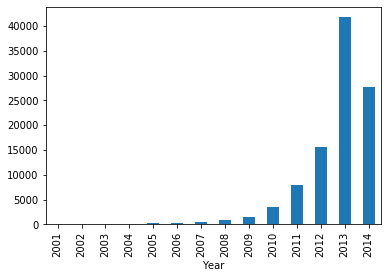

In [0]:
groups_year = df.groupby(['Year']).size()
groups_year.plot.bar()

2. Counts of reviews' numbers by with month

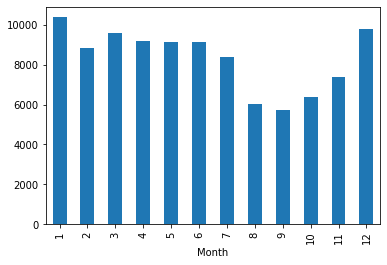

In [0]:
groups_year = df.groupby(['Month']).size()
groups_year.plot.bar()

3. Check the distribution for different ratings after 2010

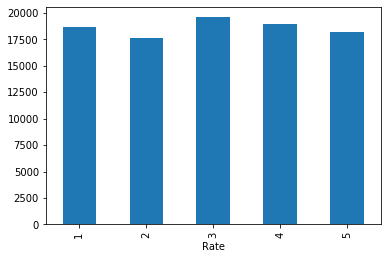

In [0]:
groups_rate_early = df[df["Year"]> 2010].groupby(['Rate']).size()
groups_rate_early.plot.bar()


4. check the distribution for different ratings befor 2010

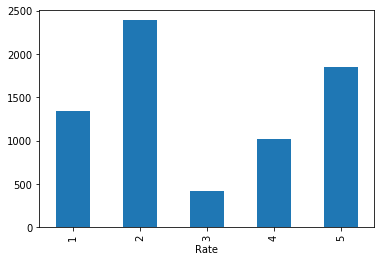

In [0]:
groups_rate_late = df[df["Year"]<= 2010].groupby(['Rate']).size()
groups_rate_late.plot.bar()

5. check the average ratings by year

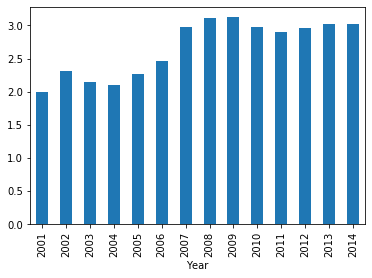

In [0]:
df_year_averaged = df.groupby(["Year"]).mean()
df_year_averaged["Rate"].plot.bar()


6. check the average ratings by month

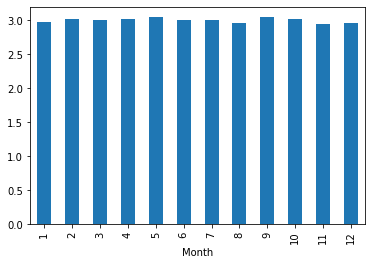

In [0]:
df_year_averaged = df.groupby(["Month"]).mean()
df_year_averaged["Rate"].plot.bar()

From the plots above, we could find that the influence from different years might be larger than by different months. The reason is the total number of different ratings seems similar if we analysize it by month. Therefore, in the next part, we will try to add the year column to the previous dataset (the one with 1000 dimensions after PCA)

### 4.3 Add the year column into the training dataset

From the analyse above, we could find that there does have influence from date, especially from year. Therefore, in the part, we will add the year information to the x dataset. To achieve this goal, we need to do:


1.   standarize the year column
2.   add the year column to the tfidf data
3.   retrain the random forest model



#### 4.3.1: standarize the year column

In [0]:


from sklearn import preprocessing
df[["Year"]] = preprocessing.StandardScaler().fit_transform(df[["Year"]])
x_year = df["Year"].to_numpy()
print(X.shape)
print(x_year.shape)


(100000, 1000)
(100000,)


#### 4.3.2: add the year column to the TF-IDF data

In [0]:
X_final = np.vstack((X.T, x_year.T)).T
print(X_final.shape)

(100000, 1001)


#### 4.3.3: use the 1001 dimensions new data to retrain the best LSTMs model

Since last time we use 2 epochs to get a pretty good model and the training after that did not improve any more, also, considering the time consuming, we would only train 3 epochs just for comparing the influence. Hope a good result :)



In [0]:
Y = pd.get_dummies(df_2w['Rate']).values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(80000, 1001) (80000, 5)
(20000, 1001) (20000, 5)


In [0]:
# Use the Keras tokenizer

num_words = 18716 # the length of vocabulary
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_2w['Text'].values)

# Pad the data 
X = tokenizer.texts_to_sequences(df_2w['Text'].values)
X = pad_sequences(X, maxlen=1000)

# Build out our simple LSTM
embed_dim = 256
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model2 = Sequential()
model2.add(Embedding(input_dim=18716, output_dim=256, input_length = 1001))
model2.add(Dropout(0.3))
model2.add(LSTM(256, recurrent_dropout=0.3, dropout=0.3))
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(5,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model2.summary())


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1001, 256)         4791296   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1001, 256)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 5,383,685
Trainable params: 5,383,685
Non-trainable params: 0
____________________________________________

In [0]:
batch_size = 512
model2.fit(X_train, Y_train, epochs=3, batch_size=batch_size, validation_split=0.2,callbacks=[ckpt_callback])

Train on 64000 samples, validate on 16000 samples
Epoch 1/3
64000/64000 [==============================] - 381s 6ms/step - loss: 1.6065 - acc: 0.2123 - val_loss: 1.5978 - val_acc: 0.2204

Epoch 00001: val_loss improved from inf to 1.59781, saving model to keras_model
Epoch 2/3
64000/64000 [==============================] - 378s 6ms/step - loss: 1.5972 - acc: 0.2299 - val_loss: 1.5956 - val_acc: 0.2368

Epoch 00002: val_loss improved from 1.59781 to 1.59563, saving model to keras_model
Epoch 3/3
64000/64000 [==============================] - 384s 6ms/step - loss: 1.5963 - acc: 0.2333 - val_loss: 1.5951 - val_acc: 0.2368

Epoch 00003: val_loss improved from 1.59563 to 1.59507, saving model to keras_model


In [0]:
model2 = load_model('keras_model')

In [0]:
model2.evaluate(X_test, Y_test)

20000/20000 [==============================] - 462s 23ms/step


[1.5934274448394776, 0.2377]

Unfortunately, the result did not improve the model and this seems the year was not improtant as we thought. Another reason for this might be the distribution is imbalanced. For example, people bought more things recent years. 

##Summary:

The aim of this project was to do some quick exploration of the dataset and apply some common ML techniques to the classification task and see which one might have the best accuracy in test dataset.

A big part of the problem is to teach an ML model how to "read" reviews literature and classify the given reviews' content and reviews' time into 1 out of 5 rating classes.

After preparing necessary methods and data in section 0. In the first part of this project, we inherit the Random Forest model from the hw4 and try to improving it by doing more hyperparameter tunning. However, this idea didn't work well and improve the accuracy.

Thus, the second part of this notebook focused on applying common techniques in ML totrain and predict reviews' eatings and evaluate their effectiveness by evalauting their accuracy. However, all the results did not show much improvement.


> The classifiers used, from least effective to most effective, were: Logistic Regression > AdaBoost Classifier > Gaussian Naive Bayes




Because the above approaches did not take into account the seuqences in reviews' text, incluing the random forest, their accuracies seem not so good.

In the third part of this notebook, we tried two neural networks. The first one is a simple NN and after 100 epochs, we found the accuracy did improvement (up to more than 81.5%) and which was a good promising direction. Then we built a more complex LSTM model, which is frequently used in text classification and got pretty high accuracy of *more than 86.87%.*

In the last part of the notebook, after comparing the possible influence from year of date and month of date, I added the "Year" feature next to the previous 1000 features( the one we got after cutoff as 1000). I tried it on our best model LSTM, and found that the results did not improve and dropped. 

